In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
from sklearn.preprocessing import StandardScaler
import torch
import tensorflow as tf
tf.compat.v1.disable_v2_behavior()
import torch.nn as nn

SEED = 1
torch.manual_seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

Instructions for updating:
non-resource variables are not supported in the long term


In [4]:
x = np.random.normal(size=(300, 50))
y = x[:,20] + x[:,40] + np.random.normal(scale = 0.01, size=300)

ss = StandardScaler()
x = ss.fit_transform(x)

In [5]:
X_train = x[:200]
y_train = y[:200]
X_test = x[200:]
y_test = y[200:]

X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).view(-1, 1).float()

X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).view(-1, 1).float()

datasets = torch.utils.data.TensorDataset(X_train, y_train)
train_iter = torch.utils.data.DataLoader(datasets, batch_size=10, shuffle=True)

In [6]:
batch_size = 50
num_epochs = 200
learning_rate = 0.0001
size_hidden1 = 50
size_hidden2 = 50
size_hidden3 = 1

In [7]:
class MyModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin1 = nn.Linear(50, size_hidden1)
        self.relu1 = nn.ReLU()
        self.lin2 = nn.Linear(size_hidden1, size_hidden2)
        self.relu2 = nn.ReLU()
        self.lin3 = nn.Linear(size_hidden2, size_hidden3)

    def forward(self, input):
        return self.lin3(self.relu2(self.lin2(self.relu1(self.lin1(input)))))
    
    def predict(self, input):
        x = torch.Tensor(input)
        return self.forward(x).detach().numpy()

In [8]:
model = MyModel()
model.train()

MyModel(
  (lin1): Linear(in_features=50, out_features=50, bias=True)
  (relu1): ReLU()
  (lin2): Linear(in_features=50, out_features=50, bias=True)
  (relu2): ReLU()
  (lin3): Linear(in_features=50, out_features=1, bias=True)
)

In [9]:
criterion = nn.MSELoss(reduction='sum')

def train(model_inp, num_epochs = num_epochs):
    optimizer = torch.optim.Adam(model_inp.parameters(), lr=learning_rate)
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        running_loss = 0.0
        for inputs, labels in train_iter:
            # forward pass
            outputs = model_inp(inputs)
            # defining loss
            loss = criterion(outputs, labels)
            # zero the parameter gradients
            optimizer.zero_grad()
            # computing gradients
            loss.backward()
            # accumulating running loss
            running_loss += loss.item()
            # updated weights based on computed gradients
            optimizer.step()
        if epoch % 20 == 0:    
            print('Epoch [%d]/[%d] running accumulative loss across all batches: %.3f' %
                  (epoch + 1, num_epochs, running_loss))
        running_loss = 0.0

In [10]:
train(model)

Epoch [1]/[200] running accumulative loss across all batches: 439.896
Epoch [21]/[200] running accumulative loss across all batches: 352.360
Epoch [41]/[200] running accumulative loss across all batches: 129.876
Epoch [61]/[200] running accumulative loss across all batches: 23.221
Epoch [81]/[200] running accumulative loss across all batches: 6.824
Epoch [101]/[200] running accumulative loss across all batches: 2.604
Epoch [121]/[200] running accumulative loss across all batches: 1.025
Epoch [141]/[200] running accumulative loss across all batches: 0.374
Epoch [161]/[200] running accumulative loss across all batches: 0.121
Epoch [181]/[200] running accumulative loss across all batches: 0.035


In [11]:
from sklearn.metrics import mean_squared_error
model.eval()
outputs = model(X_test).detach().numpy()
err = np.sqrt(mean_squared_error(outputs, y_test.detach().numpy()))
print(err)

0.5316393


Text(0, 0.5, 'Label')

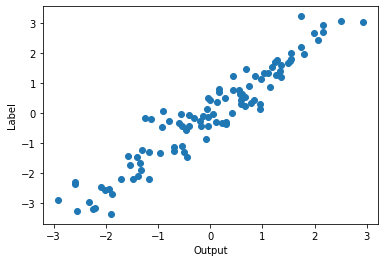

In [12]:
outputs = pd.Series(outputs[:,0], index=range(200,300))
plt.scatter(outputs, y[200:])
plt.xlabel("Output")
plt.ylabel("Label")

In [13]:
def get_masked_data_for_CXPlain(model, x):
    x_train = torch.FloatTensor(x)

    n_feats = x.shape[1]
    patch = 5
    mask = np.ones((n_feats//patch, n_feats))
    for i in range(n_feats//patch):
        mask[i, i*patch:(i+1)*patch] = 0
    
    y_pred = model(x_train).detach().numpy()
    
    mask = torch.FloatTensor(mask)
    
    list_of_masked_outs = []
    for i, sample in enumerate(x_train):
        masked_sample = sample*mask
        list_of_masked_outs.append(model(masked_sample).unsqueeze(0).detach().numpy())
    
    masked_outs = np.concatenate(list_of_masked_outs)
    return(x, y_pred, masked_outs)

In [14]:
k = get_masked_data_for_CXPlain(model, x[:200])

In [15]:
k[2].shape

(200, 10, 1)

In [16]:
from tensorflow.python.keras.losses import mean_squared_error as loss
from cxplain import CXPlain
from cxplain.backend.model_builders.custom_mlp import CustomMLPModelBuilder
model_builder = CustomMLPModelBuilder(num_layers=2, num_units=32, batch_size=32, learning_rate=0.001, n_feature_groups=10)

explainer = CXPlain(model, model_builder, None, loss)

In [17]:
 explainer.fit(x[:200], y[:200], masked_data=k)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


TensorflowCXPlain(explained_model=MyModel(
  (lin1): Linear(in_features=50, out_features=50, bias=True)
  (relu1): ReLU()
  (lin2): Linear(in_features=50, out_features=50, bias=True)
  (relu2): ReLU()
  (lin3): Linear(in_features=50, out_features=1, bias=True)
),
                  loss=<function mean_squared_error at 0x7f83d98dd320>,
                  masking_operation=None,
                  model_builder=<cxplain.backend.model_builders.custom_mlp.CustomMLPModelBuilder object at 0x7f83c0616bd0>)

In [18]:
attributions = explainer.explain_groups(x[200:])

In [19]:
attr = pd.DataFrame(attributions, index=range(200, 300))

In [20]:
attr

,0,1,2,3,4,5,6,7,8,9
200,0.025425,0.027739,0.017831,0.014815,0.586638,0.009306,0.047379,0.029204,0.222251,0.019412
201,0.048754,0.056273,0.045600,0.047916,0.343268,0.039123,0.062425,0.057032,0.266324,0.033284
202,0.027686,0.029629,0.039398,0.024253,0.337479,0.052549,0.027971,0.032493,0.413223,0.015319
203,0.027752,0.019585,0.016664,0.018219,0.359896,0.019714,0.016892,0.007839,0.505770,0.007668
204,0.040666,0.027040,0.056323,0.043972,0.409793,0.041008,0.032931,0.041874,0.256727,0.049666
...,...,...,...,...,...,...,...,...,...,...
295,0.032653,0.031163,0.021347,0.026971,0.395792,0.025908,0.026744,0.033161,0.391794,0.014468
296,0.020350,0.055543,0.022955,0.029615,0.470825,0.022906,0.093073,0.034494,0.232881,0.017358
297,0.015303,0.058987,0.049969,0.045691,0.493522,0.040458,0.068033,0.018246,0.172036,0.037755
298,0.039733,0.014240,0.013280,0.012049,0.230295,0.040951,0.030776,0.009612,0.598416,0.010647


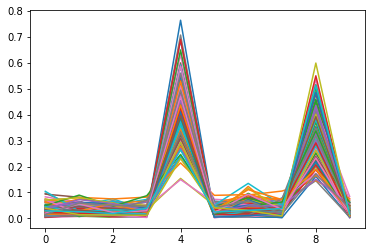

In [21]:
for i in attr.index:
    plt.plot(range(10), attr.loc[i].values)
plt.show()

# Pathway toy example

In [22]:
x = np.random.normal(size=(300, 50))
y = np.zeros((300))

for i in range(10):
    y += x[:,i*5]
# y += np.random.normal(scale = 0.01, size=300)

ss = StandardScaler()
x = ss.fit_transform(x)

In [23]:
X_train = x[:200]
y_train = y[:200]
X_test = x[200:]
y_test = y[200:]

X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).view(-1, 1).float()

X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).view(-1, 1).float()

datasets = torch.utils.data.TensorDataset(X_train, y_train)
train_iter = torch.utils.data.DataLoader(datasets, batch_size=10, shuffle=True)

In [24]:
model = MyModel()
model.train()
train(model, num_epochs=300)

Epoch [1]/[300] running accumulative loss across all batches: 2004.451
Epoch [21]/[300] running accumulative loss across all batches: 1738.979
Epoch [41]/[300] running accumulative loss across all batches: 764.751
Epoch [61]/[300] running accumulative loss across all batches: 100.574
Epoch [81]/[300] running accumulative loss across all batches: 33.431
Epoch [101]/[300] running accumulative loss across all batches: 16.199
Epoch [121]/[300] running accumulative loss across all batches: 8.163
Epoch [141]/[300] running accumulative loss across all batches: 3.950
Epoch [161]/[300] running accumulative loss across all batches: 1.843
Epoch [181]/[300] running accumulative loss across all batches: 0.785
Epoch [201]/[300] running accumulative loss across all batches: 0.307
Epoch [221]/[300] running accumulative loss across all batches: 0.107
Epoch [241]/[300] running accumulative loss across all batches: 0.033
Epoch [261]/[300] running accumulative loss across all batches: 0.009
Epoch [281]/[3

0.83806694


Text(0, 0.5, 'Label')

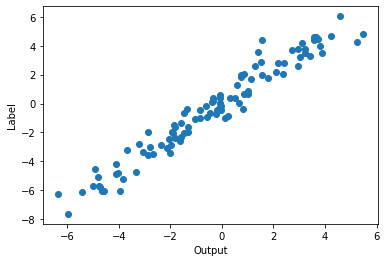

In [25]:
model.eval()
outputs = model(X_test).detach().numpy()
err = np.sqrt(mean_squared_error(outputs, y_test.detach().numpy()))
print(err)

outputs = pd.Series(outputs[:,0], index=range(200,300))
plt.scatter(outputs, y[200:])
plt.xlabel("Output")
plt.ylabel("Label")

In [26]:
from cxplain import MLPModelBuilder, ZeroMasking
model_builder = MLPModelBuilder(num_layers=2, num_units=32, batch_size=32, learning_rate=0.001)
masking_operation = ZeroMasking()

explainer = CXPlain(model, model_builder, masking_operation, loss)
explainer.fit(x[:200], y[:200])

TensorflowCXPlain(explained_model=MyModel(
  (lin1): Linear(in_features=50, out_features=50, bias=True)
  (relu1): ReLU()
  (lin2): Linear(in_features=50, out_features=50, bias=True)
  (relu2): ReLU()
  (lin3): Linear(in_features=50, out_features=1, bias=True)
),
                  loss=<function mean_squared_error at 0x7f83d98dd320>,
                  masking_operation=<cxplain.backend.masking.zero_masking.ZeroMasking object at 0x7f83c0307ed0>,
                  model_builder=<cxplain.backend.model_builders.mlp.MLPModelBuilder object at 0x7f838c234a50>)

In [27]:
attributions = explainer.explain(x[200:])
attr = pd.DataFrame(attributions, index=range(200, 300))
attr

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
200,0.077966,0.010587,0.008194,0.008159,0.005858,0.058725,0.005561,0.008842,0.007985,0.008663,...,0.091379,0.006877,0.019389,0.004711,0.005634,0.050959,0.012744,0.006804,0.009205,0.005259
201,0.136029,0.000300,0.000076,0.000214,0.000131,0.065562,0.000106,0.000236,0.000417,0.000612,...,0.058232,0.000171,0.002594,0.000188,0.000326,0.094033,0.000910,0.000240,0.000747,0.000114
202,0.071550,0.001215,0.000560,0.002169,0.001065,0.096918,0.000613,0.001099,0.003544,0.000882,...,0.124205,0.002062,0.007906,0.001470,0.002580,0.123384,0.004409,0.001856,0.002729,0.001159
203,0.071972,0.007044,0.004470,0.003898,0.010381,0.074109,0.005883,0.007451,0.009175,0.009711,...,0.036449,0.006031,0.016665,0.007782,0.006075,0.072489,0.012224,0.004697,0.012351,0.007418
204,0.183781,0.001631,0.000611,0.001377,0.001110,0.108334,0.001511,0.002463,0.004057,0.001583,...,0.105645,0.001948,0.006173,0.001103,0.002201,0.059430,0.004280,0.001419,0.004588,0.001202
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,0.297202,0.001247,0.000502,0.001213,0.001753,0.092429,0.000410,0.001393,0.001214,0.000704,...,0.085982,0.001047,0.003738,0.000653,0.001454,0.093185,0.005518,0.001162,0.001895,0.000807
296,0.074317,0.000836,0.000347,0.000474,0.000947,0.135114,0.000328,0.000908,0.000708,0.002327,...,0.108553,0.000944,0.003324,0.000746,0.001125,0.118299,0.002569,0.000658,0.003287,0.000584
297,0.100125,0.001301,0.000369,0.000760,0.002762,0.087097,0.000779,0.001320,0.001452,0.004515,...,0.051717,0.000666,0.010530,0.001197,0.004009,0.099662,0.003411,0.004635,0.003753,0.002628
298,0.182021,0.000764,0.001157,0.000483,0.001037,0.079537,0.000614,0.001414,0.000924,0.002876,...,0.046754,0.000297,0.007171,0.000328,0.001493,0.033156,0.003275,0.001459,0.003391,0.000969


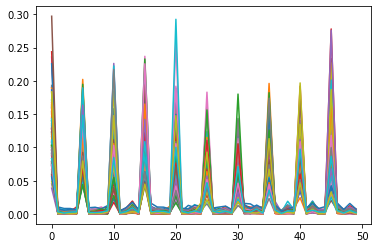

In [28]:
for i in attr.index:
    plt.plot(range(50), attr.loc[i].values)
plt.show()

In [29]:
def get_masked_pathways_for_CXPlain(model, x):
    x_train = torch.FloatTensor(x)

    n_pathways = 8
    n_feats = 50
    mask = np.zeros((n_pathways, n_feats))
    mask[0] = [0 if i%5!=0 else 1 for i in range(50)] # 10 features div by 5 {all important}
    mask[1] = [0 if i%10!=0 else 1 for i in range(50) ] # 5 features div by 10 {half of the important features}
    mask[2] = [0 if (i+1)%5!=0 else 1 for i in range(50)] # 10 trivial features 
    mask[3] = [0 if (i+2)%10!=0 else 1 for i in range(50)] # 5 trivial features {8, 18, 28, 38, 48}
    mask[4] = mask[1] + mask[3] # 5 trivial + 5 important
    mask[5] = mask[0] + mask[2] # 10 trivial + 10 important
    mask[6] = mask[0] + mask[3] # 5 trivial + 10 important 
    mask[7] = mask[1] + mask[2] # 10 trivial + 5 important

    # expected: 0 > 6 > {5 ? 4} > 7 > {2 ? 3}
    
    # remove those in "pathway"
    mask = np.ones((n_pathways, n_feats)) - mask
    
    y_pred = model(x_train).detach().numpy()  
    mask = torch.FloatTensor(mask)
    
    list_of_masked_outs = []
    for i, sample in enumerate(x_train):
        masked_sample = sample*mask
        list_of_masked_outs.append(model(masked_sample).unsqueeze(0).detach().numpy())
    
    masked_outs = np.concatenate(list_of_masked_outs)
    return(x, y_pred, masked_outs)

In [30]:
k = get_masked_pathways_for_CXPlain(model, x[:200])
print(k[2].shape)

(200, 8, 1)


In [31]:
model_builder = CustomMLPModelBuilder(num_layers=2, num_units=32, batch_size=32, learning_rate=0.001, n_feature_groups=8)
explainer = CXPlain(model, model_builder, None, loss)
explainer.fit(x[:200], y[:200], masked_data=k)

TensorflowCXPlain(explained_model=MyModel(
  (lin1): Linear(in_features=50, out_features=50, bias=True)
  (relu1): ReLU()
  (lin2): Linear(in_features=50, out_features=50, bias=True)
  (relu2): ReLU()
  (lin3): Linear(in_features=50, out_features=1, bias=True)
),
                  loss=<function mean_squared_error at 0x7f83d98dd320>,
                  masking_operation=None,
                  model_builder=<cxplain.backend.model_builders.custom_mlp.CustomMLPModelBuilder object at 0x7f838c46f990>)

In [32]:
attributions = explainer.explain_groups(x[200:])
attr = pd.DataFrame(attributions, index=range(200, 300))
attr

,0,1,2,3,4,5,6,7
200,0.355130,0.071529,0.006083,0.004082,0.075649,0.114559,0.285634,0.087334
201,0.092074,0.135609,0.006665,0.009301,0.214600,0.100960,0.263416,0.177375
202,0.288347,0.120732,0.015973,0.027580,0.105332,0.116249,0.250404,0.075382
203,0.134480,0.125903,0.008858,0.011781,0.107638,0.291560,0.174255,0.145525
204,0.193345,0.150035,0.004494,0.003397,0.054877,0.213786,0.271845,0.108222
...,...,...,...,...,...,...,...,...
295,0.114423,0.176248,0.020274,0.024142,0.156096,0.103373,0.140955,0.264489
296,0.181987,0.110319,0.003024,0.029216,0.204902,0.134387,0.209150,0.127015
297,0.163571,0.183404,0.011062,0.010308,0.100064,0.189251,0.230465,0.111876
298,0.121883,0.105266,0.005712,0.005361,0.194363,0.226290,0.180201,0.160924


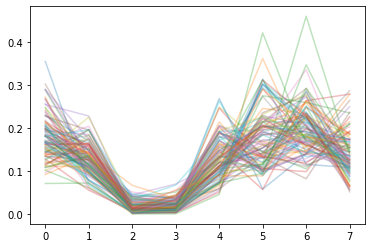

In [33]:
for i in attr.index:
    plt.plot(range(8), attr.loc[i].values, alpha=0.3)
plt.show()

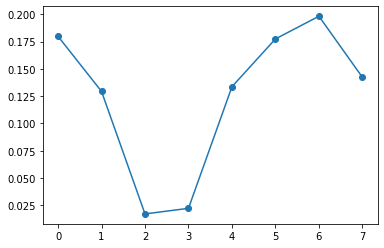

In [34]:
plt.plot(range(8), attr.mean(axis=0).values, marker='o')
# expected: 0 > {1 ? 6} > {5 ? 4} > 7 > {2 ? 3}

0: 10 important

1: 5 important

2: 10 trivial

3: 5 trivial

4: 5 important + 5 trivial

5: 10 important + 10 trivial

6: 10 important + 5 trivial

7: 5 important + 10 trivial

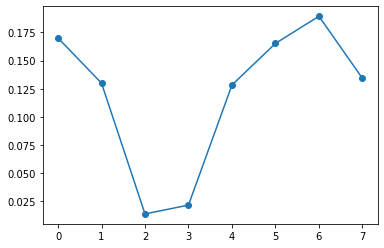

In [35]:
plt.plot(range(8), attr.median(axis=0).values, marker='o')

**NOTES:** 
 - attr[6] > attr[0] : This is not good because group 6 has 5 nuisance features
 - attr[6] > attr[5] : This is good because group 6 has less nuisance features than group 5
 - attr[3] > attr[2] : 5 trivial > 10 trivial?
 - attr[7] > attr[4] > attr[1]: This shows the bias towards the cardinality of zeroed features

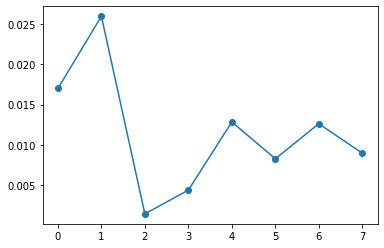

In [36]:
n_zero = np.asarray([10, 5, 10, 5, 10, 20, 15, 15])
k = attr.median(axis=0).values/n_zero
plt.plot(range(8), k, marker='o')

# All groups have 10 important features and i nuisance

In [37]:
def get_masked_pathways_for_CXPlain2(model, x):
    x_train = torch.FloatTensor(x)

    n_pathways = 41
    n_feats = 50
    mask = np.zeros((n_pathways, n_feats))
    mask[0] = [0 if i%5!=0 else 1 for i in range(50)] # 10 features div by 5 {all important}
    
    print(np.nonzero(1-mask[0]))
    
    for i, j in enumerate(np.nonzero(1-mask[0])[0]): # 10 important, i trivial
        mask[i+1] = mask[i]
        mask[i+1, j] = 1
        
    # remove those in "pathway"
    mask = np.ones((n_pathways, n_feats)) - mask
    print(mask.sum(axis=1))
    
    y_pred = model(x_train).detach().numpy()  
    mask = torch.FloatTensor(mask)
    
    list_of_masked_outs = []
    for i, sample in enumerate(x_train):
        masked_sample = sample*mask
        list_of_masked_outs.append(model(masked_sample).unsqueeze(0).detach().numpy())
    
    masked_outs = np.concatenate(list_of_masked_outs)
    return(x, y_pred, masked_outs)

In [38]:
k = get_masked_pathways_for_CXPlain2(model, x[:200])

(array([ 1,  2,  3,  4,  6,  7,  8,  9, 11, 12, 13, 14, 16, 17, 18, 19, 21,
       22, 23, 24, 26, 27, 28, 29, 31, 32, 33, 34, 36, 37, 38, 39, 41, 42,
       43, 44, 46, 47, 48, 49]),)
[40. 39. 38. 37. 36. 35. 34. 33. 32. 31. 30. 29. 28. 27. 26. 25. 24. 23.
 22. 21. 20. 19. 18. 17. 16. 15. 14. 13. 12. 11. 10.  9.  8.  7.  6.  5.
  4.  3.  2.  1.  0.]


In [39]:
k[2].shape

(200, 41, 1)

In [40]:
model_builder = CustomMLPModelBuilder(num_layers=2, num_units=32, batch_size=32, learning_rate=0.001, n_feature_groups=41)
explainer = CXPlain(model, model_builder, None, loss, num_models=3)
explainer.fit(x[:200], y[:200], masked_data=k)

TensorflowCXPlain(explained_model=MyModel(
  (lin1): Linear(in_features=50, out_features=50, bias=True)
  (relu1): ReLU()
  (lin2): Linear(in_features=50, out_features=50, bias=True)
  (relu2): ReLU()
  (lin3): Linear(in_features=50, out_features=1, bias=True)
),
                  loss=<function mean_squared_error at 0x7f83d98dd320>,
                  masking_operation=None,
                  model_builder=<cxplain.backend.model_builders.custom_mlp.CustomMLPModelBuilder object at 0x7f837c41e290>,
                  num_models=3)

In [41]:
attributions, conf = explainer.explain_groups(x[200:])

In [42]:
conf.shape

(100, 41, 2)

In [43]:
attributions.shape

(100, 41)

In [44]:
# attributions = explainer.explain_groups(x[200:])
attr = pd.DataFrame(attributions, index=range(200, 300))
attr

,0,1,2,3,4,5,6,7,8,9,...,31,32,33,34,35,36,37,38,39,40
200,0.023823,0.021028,0.016100,0.025282,0.028350,0.020265,0.021113,0.022758,0.022675,0.026530,...,0.031198,0.027682,0.023460,0.024390,0.020598,0.027500,0.019696,0.032258,0.028241,0.024551
201,0.022804,0.023392,0.026958,0.028706,0.024327,0.022312,0.026655,0.019233,0.025584,0.022681,...,0.022630,0.024168,0.024940,0.022206,0.021840,0.030131,0.026180,0.025728,0.025793,0.022502
202,0.019416,0.023845,0.025653,0.022234,0.023382,0.022148,0.022921,0.019473,0.028585,0.024001,...,0.024044,0.026628,0.022406,0.026058,0.025619,0.023084,0.026073,0.025111,0.032395,0.026216
203,0.021776,0.020629,0.023306,0.025088,0.020791,0.022272,0.022161,0.024147,0.027096,0.027018,...,0.027981,0.022733,0.025185,0.025160,0.024338,0.023046,0.023554,0.023062,0.022845,0.025656
204,0.023108,0.031739,0.026937,0.019342,0.026178,0.021693,0.024243,0.022468,0.025644,0.024827,...,0.023664,0.019404,0.021268,0.021945,0.023322,0.019914,0.023067,0.027033,0.025497,0.019988
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,0.020623,0.019330,0.022109,0.020884,0.025152,0.022131,0.024075,0.020847,0.024850,0.021889,...,0.030304,0.026641,0.026365,0.027411,0.023297,0.020942,0.029016,0.030991,0.032177,0.026006
296,0.036181,0.017800,0.020812,0.032549,0.019124,0.016545,0.018928,0.023971,0.024400,0.025233,...,0.026182,0.027160,0.024852,0.026863,0.021002,0.019053,0.022471,0.029526,0.022082,0.024407
297,0.020064,0.021256,0.020379,0.023397,0.030028,0.023100,0.019715,0.021137,0.023520,0.030168,...,0.024965,0.021631,0.026207,0.020912,0.022301,0.020729,0.027980,0.021432,0.021860,0.022188
298,0.021817,0.020096,0.021967,0.026883,0.023741,0.025345,0.025250,0.020984,0.027419,0.024085,...,0.026421,0.024300,0.024695,0.026841,0.020769,0.022169,0.024426,0.022696,0.025169,0.019781


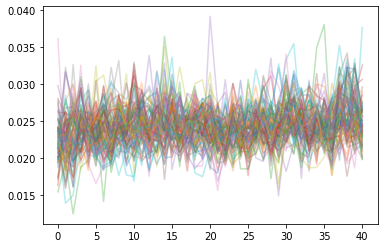

In [45]:
for i in attr.index:
    plt.plot(range(41), attr.loc[i].values, alpha=0.3)
plt.show()

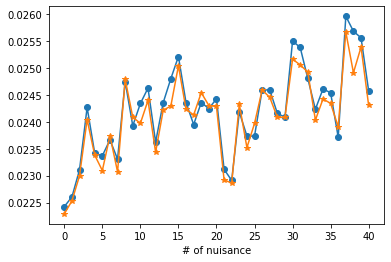

In [46]:
plt.plot(range(41), attr.mean(axis=0).values, marker='o', label='mean')
plt.plot(range(41), attr.median(axis=0).values, marker='*', label='median')
plt.xlabel('# of nuisance')
plt.show()

In [48]:
attr.sum(axis=1)

200    0.985957
201    0.986558
202    0.990332
203    0.991677
204    0.985000
         ...   
295    1.006952
296    0.984610
297    0.977205
298    0.983038
299    0.995563
Length: 100, dtype: float32

**NOTE:** If all "pathways" have the same 10 important features, more zeroed features can mean higher attribution even if most of them are nuisance features only. However, the differences might be a bit smaller.

try the completely irrelevant ones

some vs none (check size bias)

# 10-i Important and i nuisance features per group

In [100]:
def get_masked_pathways_for_CXPlain3(model, x):
    x_train = torch.FloatTensor(x)

    n_pathways = 11
    n_feats = 50
    mask = np.zeros((n_pathways, n_feats))
    mask[0] = [0 if i%5!=0 else 1 for i in range(50)] # 10 features div by 5 {all important}
    
    for i, j in enumerate(np.nonzero(mask[0])[0]): # 10-i important, i trivial
        mask[i+1] = mask[i]
        mask[i+1, j] = 0
        mask[i+1, j+1] = 1
        
    # remove those in "pathway"
    mask = np.ones((n_pathways, n_feats)) - mask
    print(mask)
    
    y_pred = model(x_train).detach().numpy()  
    mask = torch.FloatTensor(mask)
    
    list_of_masked_outs = []
    for i, sample in enumerate(x_train):
        masked_sample = sample*mask
        list_of_masked_outs.append(model(masked_sample).unsqueeze(0).detach().numpy())
    
    masked_outs = np.concatenate(list_of_masked_outs)
    return(x, y_pred, masked_outs)

In [101]:
k = get_masked_pathways_for_CXPlain3(model, x[:200])

[[0. 1. 1. 1. 1. 0. 1. 1. 1. 1. 0. 1. 1. 1. 1. 0. 1. 1. 1. 1. 0. 1. 1. 1.
  1. 0. 1. 1. 1. 1. 0. 1. 1. 1. 1. 0. 1. 1. 1. 1. 0. 1. 1. 1. 1. 0. 1. 1.
  1. 1.]
 [1. 0. 1. 1. 1. 0. 1. 1. 1. 1. 0. 1. 1. 1. 1. 0. 1. 1. 1. 1. 0. 1. 1. 1.
  1. 0. 1. 1. 1. 1. 0. 1. 1. 1. 1. 0. 1. 1. 1. 1. 0. 1. 1. 1. 1. 0. 1. 1.
  1. 1.]
 [1. 0. 1. 1. 1. 1. 0. 1. 1. 1. 0. 1. 1. 1. 1. 0. 1. 1. 1. 1. 0. 1. 1. 1.
  1. 0. 1. 1. 1. 1. 0. 1. 1. 1. 1. 0. 1. 1. 1. 1. 0. 1. 1. 1. 1. 0. 1. 1.
  1. 1.]
 [1. 0. 1. 1. 1. 1. 0. 1. 1. 1. 1. 0. 1. 1. 1. 0. 1. 1. 1. 1. 0. 1. 1. 1.
  1. 0. 1. 1. 1. 1. 0. 1. 1. 1. 1. 0. 1. 1. 1. 1. 0. 1. 1. 1. 1. 0. 1. 1.
  1. 1.]
 [1. 0. 1. 1. 1. 1. 0. 1. 1. 1. 1. 0. 1. 1. 1. 1. 0. 1. 1. 1. 0. 1. 1. 1.
  1. 0. 1. 1. 1. 1. 0. 1. 1. 1. 1. 0. 1. 1. 1. 1. 0. 1. 1. 1. 1. 0. 1. 1.
  1. 1.]
 [1. 0. 1. 1. 1. 1. 0. 1. 1. 1. 1. 0. 1. 1. 1. 1. 0. 1. 1. 1. 1. 0. 1. 1.
  1. 0. 1. 1. 1. 1. 0. 1. 1. 1. 1. 0. 1. 1. 1. 1. 0. 1. 1. 1. 1. 0. 1. 1.
  1. 1.]
 [1. 0. 1. 1. 1. 1. 0. 1. 1. 1. 1. 0. 1. 1. 1. 1. 0. 1. 1.

In [102]:
model_builder = CustomMLPModelBuilder(num_layers=2, num_units=32, batch_size=32, learning_rate=0.001, n_feature_groups=11)
explainer = CXPlain(model, model_builder, None, loss, num_models=3)
explainer.fit(x[:200], y[:200], masked_data=k)

TensorflowCXPlain(explained_model=MyModel(
  (lin1): Linear(in_features=50, out_features=50, bias=True)
  (relu1): ReLU()
  (lin2): Linear(in_features=50, out_features=50, bias=True)
  (relu2): ReLU()
  (lin3): Linear(in_features=50, out_features=1, bias=True)
),
                  loss=<function mean_squared_error at 0x7fef8be89cb0>,
                  masking_operation=None,
                  model_builder=<cxplain.backend.model_builders.custom_mlp.CustomMLPModelBuilder object at 0x7feee93d2d50>,
                  num_models=3)

In [103]:
attributions, conf = explainer.explain_groups(x[200:])

In [104]:
attr = pd.DataFrame(attributions, index=range(200, 300))
attr

,0,1,2,3,4,5,6,7,8,9,10
200,0.263753,0.159813,0.110995,0.111921,0.085584,0.065573,0.032384,0.028331,0.036780,0.035238,0.012348
201,0.235999,0.121739,0.115119,0.110892,0.112082,0.099771,0.050261,0.054816,0.068677,0.055102,0.031573
202,0.174126,0.143575,0.091370,0.102993,0.114153,0.058597,0.066301,0.069412,0.062604,0.034073,0.018543
203,0.167114,0.116545,0.132320,0.144763,0.058242,0.078497,0.100974,0.070488,0.071117,0.055405,0.009920
204,0.269761,0.140385,0.106550,0.083161,0.060470,0.063091,0.070041,0.068248,0.035460,0.030866,0.009811
...,...,...,...,...,...,...,...,...,...,...,...
295,0.173603,0.153591,0.124844,0.075599,0.126963,0.068573,0.059013,0.063914,0.076653,0.050102,0.013618
296,0.106872,0.126289,0.095100,0.151151,0.169168,0.063769,0.058703,0.050266,0.092036,0.043516,0.007122
297,0.184530,0.164741,0.137251,0.103146,0.113532,0.075288,0.043553,0.036994,0.041007,0.029243,0.015848
298,0.216755,0.093801,0.147261,0.151505,0.099768,0.118310,0.071823,0.028218,0.030630,0.034022,0.005899


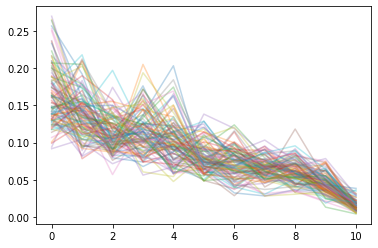

In [106]:
for i in attr.index:
    plt.plot(range(11), attr.loc[i].values, alpha=0.3)
plt.show()

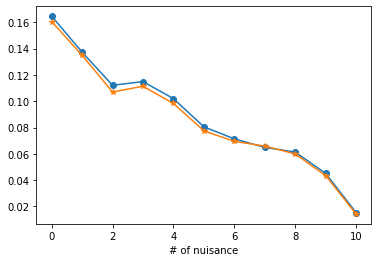

In [107]:
plt.plot(range(11), attr.mean(axis=0).values, marker='o', label='mean')
plt.plot(range(11), attr.median(axis=0).values, marker='*', label='median')
plt.xlabel('# of nuisance')
plt.show()